In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import recall_score
import matplotlib.pyplot as plt
from datetime import datetime
import optuna
import xgboost as xgb
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error
from optuna.samplers import TPESampler
import sqlalchemy
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer, accuracy_score, mean_squared_error,mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score, KFold
from xgboost import XGBClassifier
from optuna.samplers import TPESampler
from sklearn.linear_model import Ridge  # 使用 Ridge 回归代替逻辑回归
from sklearn.preprocessing import StandardScaler
from tabulate import tabulate
from scipy.stats import entropy
plt.rcParams['font.sans-serif'] = ['SimHei']  # 支持中文字体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号 '-' 显示问题


C:\Users\Acer\anaconda3\envs\transformer_git\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import warnings
from pandas.errors import PerformanceWarning

# 忽略所有PerformanceWarning
warnings.simplefilter("ignore", category=PerformanceWarning)

In [3]:
df = pd.read_csv('..\wiki_embeding_cluster\output_wiki_vectorized_sequences.csv')

In [4]:
df = df.drop(columns = ['商品名称',  '关联店铺', '商品分类', '商品品牌', '浏览量', '视频数','抖音号','商品综合信息'])
df['佣金率'] =df['佣金率'].str.replace('%', '').astype(float) / 100
df = df.dropna()
df.sort_values(by='佣金率')

df['转化率_1'] = df['转化率_编码'].apply(lambda x: 3 if x >= 3 else x)
df['转化率_1'].value_counts()

df = df.drop(columns=['转化率_编码'])


df = df.drop(columns=['视频销售额_编码', '视频销量_编码','点赞', '评论', '分享', '收藏',])
df['带货视频'] = df['带货视频'].apply(lambda x: 1 if x>0  else x)


df['销售均价最大差值'] = df['销售均价最大值'] - df['销售均价最小值']
df['销售均价'] = (df['销售均价最大值'] + df['销售均价最小值']) /2

df['商品价格最大差值'] = df['商品价格最大值'] - df['商品价格最小值']
df['商品价格中位数'] = (df['商品价格最大值'] + df['商品价格最小值']) /2

df = df.drop(columns=['销售均价最大值','销售均价最小值','商品价格最大值','商品价格最小值'])


In [5]:
df['销售均价_groupby_cluster'] = df.groupby(by = 'cluster_similarity')['销售均价'].transform(lambda x: (x - x.mean()) / x.std())
df['商品价格中位数_groupby_cluster'] = df.groupby(by = 'cluster_similarity')['商品价格中位数'].transform(lambda x: (x - x.mean()) / x.std())

# 计算每个 cluster_label 内的分位数并分类
def assign_percentile_group(x):
    quantiles = [0, 0.4, 0.7, 0.9, 1.0]
    quantile_labels = [ 'per60-100', 'per30-60', 'per10-30','per0-10']
    q_bins = np.quantile(x, quantiles)  # 计算当前组的分位数边界
    return pd.cut(x, bins=q_bins, labels=quantile_labels, include_lowest=True)

df['销售均价分位数'] = df.groupby('cluster_similarity')['销售均价'].transform(assign_percentile_group)

df = df.drop(columns = ['销售均价'])

In [6]:
X = df.drop(columns = ['转化率_1'])
y = df['转化率_1']
# 拆分训练集和测试集（70%训练，30%测试）
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

train = X_train.copy()
train['转化率_1'] = y_train

test = X_test.copy()

target = '转化率_1'

In [7]:
from prettytable import PrettyTable
table = PrettyTable()
table.field_names = ['Column Name', 'Data Type', 'Train Missing %', 'Test Missing %']
for column in X_train.columns:
    data_type = str(train[column].dtype)
    non_null_count_train  = 100 - train[column].count()/train.shape[0] * 100
    if column != target:
        non_null_count_test = 100 - test[column].count()/test.shape[0] * 100
    else:
        non_null_count_test = 'NA'
    table.add_row([column,data_type,non_null_count_train,non_null_count_test])
print(table)

+--------------------------------+-----------+-----------------+----------------+
|          Column Name           | Data Type | Train Missing % | Test Missing % |
+--------------------------------+-----------+-----------------+----------------+
|             佣金率             |  float64  |       0.0       |      0.0       |
|            带货视频            |  float64  |       0.0       |      0.0       |
|            带货直播            |  float64  |       0.0       |      0.0       |
|             粉丝数             |   int64   |       0.0       |      0.0       |
|          销售额_编码           |   int64   |       0.0       |      0.0       |
|           销量_编码            |   int64   |       0.0       |      0.0       |
|        直播销售额_编码         |   int64   |       0.0       |      0.0       |
|         直播销量_编码          |   int64   |       0.0       |      0.0       |
|          上架距今(天)          |   int64   |       0.0       |      0.0       |
|            视频热度            |  float64  |       0.0     

In [8]:
from sklearn.preprocessing import MinMaxScaler

def min_max_scaler(train, test, column):
    sc=MinMaxScaler()
    
    max_val=max(train[column].max(),test[column].max())
    min_val=min(train[column].min(),test[column].min())

    train[column]=(train[column]-min_val)/(max_val-min_val)
    test[column]=(test[column]-min_val)/(max_val-min_val)
    
    return train,test  

In [9]:
def rmse(y1,y2):
    return(np.sqrt(mean_squared_error(np.array(y1),np.array(y2))))

In [10]:
global y_unique
y_unique=train[target].unique()
# y_unique_log=np.log1p(train[target]).unique()

def nearest(y_predicted):
    
    y_original=y_unique
    modified_prediction = np.zeros_like(y_predicted)

    for i, y_pred in enumerate(y_predicted):
        nearest_value = min(y_original, key=lambda x: abs(x - y_pred))
        modified_prediction[i] = nearest_value

    return modified_prediction

In [11]:
cont_cols = [f for f in X.columns if train[f].dtype != 'O' and train[f].nunique()>10 and 'groupby' not in f]
cont_cols

['佣金率',
 '带货直播',
 '粉丝数',
 '销售额_编码',
 '销量_编码',
 '直播销售额_编码',
 '直播销量_编码',
 '上架距今(天)',
 '视频热度',
 '互动量',
 '互动率',
 'tsne_x',
 'tsne_y',
 '商品价格最大差值',
 '商品价格中位数']

## 1 Numerical Transformations

<font size="3">We're going to see what transformation works better for each feature and select them, the idea is to compress the data. There could be situations where you will have to stretch the data. These are the methods applied:</font>

1. **Log Transformation**: <font size="3">This transformation involves taking the logarithm of each data point. It is useful when the data is highly skewed and the variance increases with the mean.</font>
                y = log(x)

2. **Square Root Transformation**: <font size="3">This transformation involves taking the square root of each data point. It is useful when the data is highly skewed and the variance increases with the mean.</font>
                y = sqrt(x)

3. **Box-Cox Transformation**: <font size="3">This transformation is a family of power transformations that includes the log and square root transformations as special cases. It is useful when the data is highly skewed and the variance increases with the mean.</font>
                y = [(x^lambda) - 1] / lambda if lambda != 0
                y = log(x) if lambda = 0

4. **Yeo-Johnson Transformation**: <font size="3">This transformation is similar to the Box-Cox transformation, but it can be applied to both positive and negative values. It is useful when the data is highly skewed and the variance increases with the mean.</font>
                y = [(|x|^lambda) - 1] / lambda if x >= 0, lambda != 0
                y = log(|x|) if x >= 0, lambda = 0
                y = -[(|x|^lambda) - 1] / lambda if x < 0, lambda != 2
                y = -log(|x|) if x < 0, lambda = 2

5. **Power Transformation**: <font size="3">This transformation involves raising each data point to a power. It is useful when the data is highly skewed and the variance increases with the mean. The power can be any value, and is often determined using statistical methods such as the Box-Cox or Yeo-Johnson transformations.</font>
                y = [(x^lambda) - 1] / lambda if method = "box-cox" and lambda != 0
                y = log(x) if method = "box-cox" and lambda = 0
                y = [(x + 1)^lambda - 1] / lambda if method = "yeo-johnson" and x >= 0, lambda != 0
                y = log(x + 1) if method = "yeo-johnson" and x >= 0, lambda = 0
                y = [-(|x| + 1)^lambda - 1] / lambda if method = "yeo-johnson" and x < 0, lambda != 2
                y = -log(|x| + 1) if method = "yeo-johnson" and x < 0, lambda = 2

In [12]:
from sklearn.preprocessing import PowerTransformer,FunctionTransformer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,mean_squared_log_error, mean_absolute_error

sc=MinMaxScaler()

global unimportant_features
global overall_best_score
global overall_best_col
unimportant_features=[]
overall_best_score=1e5
overall_best_col='none'

def transformer(train, test,cont_cols, target):
    '''
    Algorithm applies multiples transformations on selected columns and finds the best transformation using a single variable model performance
    '''
    global unimportant_features
    global overall_best_score
    global overall_best_col
    train_copy = train.copy()
    test_copy = test.copy()
    print(train_copy.shape)
    print(test_copy.shape)
#     train_copy.fillna(train_copy.mean(), inplace=True)
#     test_copy.fillna(test_copy.mean(), inplace=True)
    
    
    table = PrettyTable()
    table.field_names = ['Feature', 'Original RMSLE', 'Transformation', 'Tranformed RMSLE']

    for col in cont_cols:
        
        # 处理负值或零值
        if (train_copy[col] <= 0).any():  # 检查是否存在负值或零值
            print(f"Negative or zero values found in {col}, applying correction...")
            # 使用clip方法将小于等于0的值设置为一个很小的正数（例如1e-5）
            train_copy[col] = train_copy[col].clip(lower=1e-3)
            test_copy[col] = test_copy[col].clip(lower=1e-3)
        
        # MinMax Scaling
        train_copy, test_copy = min_max_scaler(train_copy, test_copy, col)
        
        # 清理之前可能存在的列
        for c in ["log_" + col, "sqrt_" + col, "bx_cx_" + col, "y_J_" + col, "log_sqrt" + col, "pow_" + col, "pow2_" + col]:
            if c in train_copy.columns:
                train_copy = train_copy.drop(columns=[c])

        # Log Transformation after MinMax Scaling
        train_copy["log_" + col] = np.log1p(train_copy[col])
        test_copy["log_" + col] = np.log1p(test_copy[col])

        # Square Root Transformation
        train_copy["sqrt_" + col] = np.sqrt(train_copy[col])
        test_copy["sqrt_" + col] = np.sqrt(test_copy[col])

        # Box-Cox Transformation
        epsilon = 1e-3
        transformer = PowerTransformer(method='box-cox')
        train_copy["bx_cx_" + col] = transformer.fit_transform(train_copy[[col]] + epsilon)
        test_copy["bx_cx_" + col] = transformer.transform(test_copy[[col]] + epsilon)

        # Yeo-Johnson Transformation
        transformer = PowerTransformer(method='yeo-johnson')
        train_copy["y_J_" + col] = transformer.fit_transform(train_copy[[col]])
        test_copy["y_J_" + col] = transformer.transform(test_copy[[col]])

        # Power Transformation, 0.25
        power_transform = lambda x: np.power(x + 1 - np.min(x), 0.25)
        transformer = FunctionTransformer(power_transform)
        train_copy["pow_" + col] = transformer.fit_transform(train_copy[[col]])
        test_copy["pow_" + col] = transformer.transform(test_copy[[col]])

        # Power Transformation, 2
        power_transform = lambda x: np.power(x + 1 - np.min(x), 2)
        transformer = FunctionTransformer(power_transform)
        train_copy["pow2_" + col] = transformer.fit_transform(train_copy[[col]])
        test_copy["pow2_" + col] = transformer.transform(test_copy[[col]])

        # Log of Square Root Transformation
        train_copy["log_sqrt" + col] = np.log1p(train_copy["sqrt_" + col])
        test_copy["log_sqrt" + col] = np.log1p(test_copy["sqrt_" + col])

        temp_cols = [col, "log_" + col, "sqrt_" + col, "bx_cx_" + col, "y_J_" + col, "pow_" + col, "pow2_" + col, "log_sqrt" + col]

        if train_copy[temp_cols].isnull().any().any():
            print(f"NaN values found in {temp_cols} after transformations")
            train_copy[temp_cols] = train_copy[temp_cols].fillna(train_copy[temp_cols].median())
            test_copy[temp_cols] = test_copy[temp_cols].fillna(test_copy[temp_cols].median())

#         pca = TruncatedSVD(n_components=1)
#         x_pca_train = pca.fit_transform(train_copy[temp_cols])
#         x_pca_test = pca.transform(test_copy[temp_cols])
#         x_pca_train = pd.DataFrame(x_pca_train, columns=[col + "_pca_comb"])
#         x_pca_test = pd.DataFrame(x_pca_test, columns=[col + "_pca_comb"])
#         temp_cols.append(col + "_pca_comb")

#         test_copy = test_copy.reset_index(drop=True)


#         train_copy = pd.concat([train_copy, x_pca_train], axis='columns')
#         test_copy = pd.concat([test_copy, x_pca_test], axis='columns')

        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        rmse_scores = []
        
        for f in temp_cols:
            
            X = train_copy[[f]].values
            y = train_copy[target].values
            
            rmses = []
            for train_idx, val_idx in kf.split(X, y):
                X_train, y_train = X[train_idx], y[train_idx]
                x_val, y_val = X[val_idx], y[val_idx]
                model=LinearRegression()
                model.fit(X_train,y_train)
                y_pred=nearest(model.predict(x_val))
                rmses.append(rmse(y_val,y_pred))
                
            rmse_scores.append((f,np.mean(rmses)))
            
            if overall_best_score > np.mean(rmses):
                overall_best_score = np.mean(rmses)
                overall_best_col = f

            if f == col:
                orig_rmse = np.mean(rmses)
                
        best_col, best_rmse = sorted(rmse_scores, key=lambda x: x[1], reverse=False)[0]
        cols_to_drop = [f for f in temp_cols if f != best_col]
#         final_selection = [f for f in temp_cols if f not in cols_to_drop]
        
        if cols_to_drop:
            unimportant_features = unimportant_features + cols_to_drop
        table.add_row([col,orig_rmse,best_col ,best_rmse])
    print(table)   
    print("overall best CV RMSLE score: ",overall_best_score)
    return train_copy, test_copy


In [13]:
train, test= transformer(train, test,cont_cols, target)

(20081, 25)
(3544, 24)
Negative or zero values found in 佣金率, applying correction...
Negative or zero values found in 带货直播, applying correction...
Negative or zero values found in 销售额_编码, applying correction...
Negative or zero values found in 销量_编码, applying correction...
Negative or zero values found in 直播销售额_编码, applying correction...
Negative or zero values found in 直播销量_编码, applying correction...
Negative or zero values found in tsne_x, applying correction...
Negative or zero values found in tsne_y, applying correction...
Negative or zero values found in 商品价格最大差值, applying correction...
Negative or zero values found in 商品价格中位数, applying correction...
+------------------+--------------------+----------------------+--------------------+
|     Feature      |   Original RMSLE   |    Transformation    |  Tranformed RMSLE  |
+------------------+--------------------+----------------------+--------------------+
|      佣金率      | 0.9269365456880125 |      y_J_佣金率      | 0.920673943679106  |

In [14]:
from sklearn.cluster import KMeans
table = PrettyTable()
table.field_names = ['Cluster WOE Feature', 'RMSLE (CV-TRAIN)']
for col in cont_cols:
    sub_set=[f for f in unimportant_features if col in f]
#     print(sub_set)
    temp_train=train[sub_set]
    temp_test=test[sub_set]
    sc=StandardScaler()
    temp_train=sc.fit_transform(temp_train)
    temp_test=sc.transform(temp_test)
    model = KMeans()

    # print(ideal_clusters)
    kmeans = KMeans(n_clusters=5, n_init=10)
    kmeans.fit(np.array(temp_train))
    labels_train = kmeans.labels_

    train[col+"_unimp_cluster_WOE"] = labels_train
    test[col+"_unimp_cluster_WOE"] = kmeans.predict(np.array(temp_test))
    
    kf=KFold(n_splits=5, shuffle=True, random_state=42)
    
    X=train[[col+"_unimp_cluster_WOE"]].values
    y=train[target].values

    best_rmse=[]
    for train_idx, val_idx in kf.split(X,y):
        X_train,y_train=X[train_idx],y[train_idx]
        x_val,y_val=X[val_idx],y[val_idx]
        model=LinearRegression()
        model.fit(X_train,y_train)
        y_pred=nearest(model.predict(x_val))
        best_rmse.append(rmse(y_val,y_pred))
        
    table.add_row([col+"_unimp_cluster_WOE",np.mean(best_rmse)])
    
    if overall_best_score<np.mean(best_rmse):
            overall_best_score=np.mean(best_rmse)
            overall_best_col=col+"_unimp_cluster_WOE"
    
print(table)

+------------------------------------+--------------------+
|        Cluster WOE Feature         |  RMSLE (CV-TRAIN)  |
+------------------------------------+--------------------+
|      佣金率_unimp_cluster_WOE      | 0.9270312792148984 |
|     带货直播_unimp_cluster_WOE     | 0.9270312792148984 |
|      粉丝数_unimp_cluster_WOE      | 0.9151541318465167 |
|   销售额_编码_unimp_cluster_WOE    | 0.9270312792148984 |
|    销量_编码_unimp_cluster_WOE     | 0.8702652995333366 |
| 直播销售额_编码_unimp_cluster_WOE  | 0.9270312792148984 |
|  直播销量_编码_unimp_cluster_WOE   |  0.96815523968507  |
|   上架距今(天)_unimp_cluster_WOE   | 0.9270312792148984 |
|     视频热度_unimp_cluster_WOE     | 0.9120828290884176 |
|      互动量_unimp_cluster_WOE      | 0.8790859121819199 |
|      互动率_unimp_cluster_WOE      | 0.9007640898759744 |
|      tsne_x_unimp_cluster_WOE      | 0.9270312792148984 |
|      tsne_y_unimp_cluster_WOE      | 0.9270312792148984 |
| 商品价格最大差值_unimp_cluster_WOE | 0.9270312792148984 |
|  商品价格中位数_unimp_cluster_WOE  | 0.9

# 2.Encoding

In [15]:
cat_cols = [f for f in test.columns if (train[f].dtype != 'O' and train[f].nunique()<20 and train[f].nunique()>2 and "WOE" not in f) or (train[f].dtype == 'O') ]
print(train[cat_cols].nunique())

cluster_similarity    6
cluster_kmeans        6
cluster_dbscan        5
cluster_hdbscan       6
销售均价最大差值              6
销售均价分位数               4
dtype: int64


In [16]:
def nearest_val(target):
    return min(common, key=lambda x: abs(x - target))

cat_cols_updated=[]
for col in cat_cols:
    if train[col].dtype!="O":
#         train[f"{col}_cat"]=train[col]
#         test[f"{col}_cat"]=test[col]
        cat_cols_updated.append(f"{col}")
        uncommon=list((set(test[col].unique())| set(train[col].unique()))-(set(test[col].unique())& set(train[col].unique())))
        if uncommon:
            print('uncommon found')
            common=list(set(test[col].unique())& set(train[col].unique()))
            train[f"{col}_cat"]=train[col].apply(nearest_val)
            test[f"{col}_cat"]=test[col].apply(nearest_val)

In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression

def OHE(train_df, test_df, cols, target):
    '''
    Function for One-Hot Encoding (OHE). Combines train & test to ensure no missing categories.
    '''
    train_df = train_df.copy()
    test_df = test_df.copy()

    combined = pd.concat([train_df, test_df], axis=0)  # 合并数据
    original_test_index = test_df.index  # 记录 test 原始索引

    for col in cols:
        combined[col] = combined[col].astype(str).str.replace(".0", "", regex=False)  # 处理浮点数

        # 自定义 One-Hot 编码列名格式
        one_hot = pd.get_dummies(combined[col], dtype=int)
        one_hot.columns = [str(value) + "_" + "_OHE" for value in one_hot.columns]

        combined = pd.concat([combined, one_hot], axis=1)
#         combined.drop(columns=[col], inplace=True)  # 删除原始分类列
    
    # 重新拆分 train 和 test，确保索引一致
    train_ohe = combined.iloc[:len(train_df)].copy()
    test_ohe = combined.iloc[len(train_df):].copy()

    # 还原 test 原始索引，防止索引对不上的问题
    test_ohe.index = original_test_index  

    # 确保不误删 target（目标列在 test 里一般不存在）
    test_ohe.drop(columns=[target], errors="ignore", inplace=True)
    
    return train_ohe, test_ohe

def high_freq_ohe(train, test, extra_cols, target, n_limit=50):
    '''
    One-Hot Encoding for high-cardinality categorical variables. Keeps only top `n_limit` categories.
    '''
    train_copy = train.copy()
    test_copy = test.copy()
    original_test_index = test.index  # 记录 test 原始索引
    
    for col in extra_cols:
        counts = train_copy[col].value_counts().to_dict()
        sorted_counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)
        rare_keys = [key for key, _ in sorted_counts[n_limit:]]  # 低频类别
        rare_key_map = dict(zip(rare_keys, [9999] * len(rare_keys)))

        train_copy[col] = train_copy[col].replace(rare_key_map)
        test_copy[col] = test_copy[col].replace(rare_key_map)

    train_copy, test_copy = OHE(train_copy, test_copy, extra_cols, target)

    # 确保 test_copy 的索引不变
    test_copy.index = original_test_index  

    # 移除无信息量列（避免数据错位）
    drop_cols = [col for col in train_copy.columns if "9999" in col or train_copy[col].nunique() == 1]
    train_copy.drop(columns=drop_cols, inplace=True, errors="ignore")
    test_copy.drop(columns=drop_cols, inplace=True, errors="ignore")

    return train_copy, test_copy

def cat_encoding(train, test, cat_cols_updated, target):
    '''
    Encodes categorical features using OHE, High-Frequency Encoding, and count features.
    '''
    global overall_best_score
    global overall_best_col

    train_copy = train.copy()
    test_copy = test.copy()
    original_test_index = test.index  # 记录 test 原始索引
    
    for feature in cat_cols_updated:
        # 选择编码方式
        if train_copy[feature].nunique() <= 15:
            train_copy[feature] = train_copy[feature].astype(str) + "_" + feature
            test_copy[feature] = test_copy[feature].astype(str) + "_" + feature
            train_copy, test_copy = OHE(train_copy, test_copy, [feature], target)
        else:
            train_copy, test_copy = high_freq_ohe(train_copy, test_copy, [feature], target, n_limit=15)

        # 生成 count 统计特征
        counts = train[feature].value_counts().to_dict()
#         train_copy[feature + "_counts"] = train[feature].map(counts)
#         test_copy[feature + "_counts"] = test[feature].map(counts)

        # 生成 count_rank 特征（频次排名）
        list1 = np.arange(len(counts.values()))  # Higher rank for low count
        count_rank = dict(zip(list(counts.keys()), list1))
        train_copy[feature + "_count_label"] = train[feature].replace(count_rank).astype(float)
        test_copy[feature + "_count_label"] = test[feature].replace(count_rank).astype(float)

        temp_cols = [feature + "_counts", feature + "_count_label"]

        train_copy.drop(columns=[feature], inplace=True)
        test_copy.drop(columns=[feature], inplace=True)

        # 确保 test_copy 索引不变
        test_copy.index = original_test_index  

    print("✅ Encoding Completed! Test index is preserved.")

    return train_copy, test_copy

# 运行修正后的代码
train_encoded, test_encoded = cat_encoding(train, test, cat_cols_updated, target)

# 最后检查索引是否匹配
assert test_encoded.index.equals(test.index), "❌ Error: test_encoded index does not match test index!"
print("✅ test_encoded index is correctly aligned with test.")


✅ Encoding Completed! Test index is preserved.
✅ test_encoded index is correctly aligned with test.


In [18]:
train_encoded

,佣金率,带货视频,带货直播,粉丝数,销售额_编码,销量_编码,直播销售额_编码,直播销量_编码,上架距今(天),视频热度,...,10_销售均价最大差值__OHE,200_销售均价最大差值__OHE,40_销售均价最大差值__OHE,50_销售均价最大差值__OHE,销售均价最大差值_count_label,per0-10_销售均价分位数__OHE,per10-30_销售均价分位数__OHE,per30-60_销售均价分位数__OHE,per60-100_销售均价分位数__OHE,销售均价分位数_count_label
17097,0.000000,0.0,0.004816,0.027537,0.679987,0.421022,0.679987,0.421022,0.152625,0.258556,...,0,0,0,0,0.0,0,1,0,0,2.0
7673,0.000000,0.0,0.125240,0.000140,0.559982,0.105216,0.559982,0.105216,0.169719,0.439878,...,0,1,0,0,1.0,1,0,0,0,3.0
4175,0.000000,0.0,0.000962,0.052342,0.679987,0.421022,0.679987,0.421022,0.050061,0.380797,...,0,0,0,0,0.0,0,0,1,0,1.0
9379,0.000000,0.0,0.005779,0.308830,0.039962,0.052582,0.039962,0.052582,0.854701,0.769070,...,0,0,0,1,2.0,0,0,0,1,0.0
5631,0.018036,0.0,0.000962,0.007297,0.679987,0.368388,0.679987,0.368388,0.166056,0.149923,...,0,0,0,0,0.0,0,1,0,0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12154,0.018036,0.0,0.000962,0.124045,0.679987,0.526291,0.679987,0.526291,0.111111,0.560012,...,0,0,0,0,0.0,0,0,0,1,0.0
21953,0.000000,0.0,0.011560,0.076566,0.399976,0.210485,0.399976,0.210485,0.111111,0.322251,...,0,0,0,1,2.0,0,0,0,1,0.0
5536,0.018036,0.0,0.003853,0.007297,0.719989,0.473657,0.719989,0.473657,0.177656,0.149923,...,0,0,0,0,0.0,0,1,0,0,2.0
896,0.298597,0.0,0.001926,0.004201,0.359974,0.105216,0.359974,0.105216,0.119658,0.114902,...,0,0,0,0,0.0,0,0,0,1,0.0


# 3.Feature Elimination

In [19]:
# first_drop=[ f for f in unimportant_features if f in train.columns and 'log' not in f]
first_drop=[ f for f in unimportant_features if f in train.columns ]
train=train_encoded.drop(columns=first_drop)
test=test_encoded.drop(columns=first_drop)

In [20]:
# final_drop_list=[]

# table = PrettyTable()
# table.field_names = ['Original', 'Final Transformation', "RMSLE(CV)- Regression"]
# dt_params={'criterion': 'absolute_error'}
# threshold=0.5
# # It is possible that multiple parent features share same child features, so store selected features to avoid selecting the same feature again
# best_cols=[]

# def correlation_elimination(train,test):
#     for col in cont_cols:
#         sub_set=[f for f in train.columns if col in f and train[f].nunique()>100]
#         print(sub_set)
#         if len(sub_set)>2:
#             correlated_features = []

#             for i, feature in enumerate(sub_set):
#                 # Check correlation with all remaining features
#                 for j in range(i+1, len(sub_set)):
#                     correlation = np.abs(train[feature].corr(train[sub_set[j]]))
#                     # If correlation is greater than threshold, add to list of highly correlated features
#                     if correlation > threshold:
#                         correlated_features.append(sub_set[j])

#             # Remove duplicate features from the list
#             correlated_features = list(set(correlated_features))
#             print(correlated_features)
#             if len(correlated_features)>=2:

#                 temp_train=train[correlated_features]
#                 temp_test=test[correlated_features]

#                 #Scale before applying PCA
#                 sc=StandardScaler()
#                 temp_train=sc.fit_transform(temp_train)
#                 temp_test=sc.transform(temp_test)
#                 # Initiate PCA
#                 pca=TruncatedSVD(n_components=1)
#                 x_pca_train=pca.fit_transform(temp_train)
#                 x_pca_test=pca.transform(temp_test)
#                 x_pca_train=pd.DataFrame(x_pca_train, columns=[col+"_pca_comb_final"])
#                 x_pca_test=pd.DataFrame(x_pca_test, columns=[col+"_pca_comb_final"])
#                 train=pd.concat([train,x_pca_train],axis='columns')
#                 test=pd.concat([test,x_pca_test],axis='columns')

#                 # Clustering
#                 model = KMeans()
#                 kmeans = KMeans(n_clusters=28)
#                 kmeans.fit(np.array(temp_train))  # 训练模型

#                 # 使用训练好的kmeans模型对test数据进行预测
#                 test[col+'_final_cluster'] = kmeans.predict(np.array(temp_test))  # 确保test数据有相同的特征

#                 # 计算类别均值并映射到train和test
#                 cat_labels = train.groupby([col+"_final_cluster"])[target].mean()
#                 cat_labels2 = cat_labels.to_dict()

#                 # 将聚类标签映射为目标变量的均值
#                 train[col+"_final_cluster"] = train[col+"_final_cluster"].map(cat_labels2)
#                 test[col+"_final_cluster"] = test[col+"_final_cluster"].map(cat_labels2)

#                 correlated_features=correlated_features+[col+"_pca_comb_final",col+"_final_cluster"]
#                 # See which transformation along with the original is giving you the best univariate fit with target
#                 kf=KFold(n_splits=5, shuffle=True, random_state=42)

#                 rmse_scores = []

#                 for f in temp_cols:
#                     X = train_copy[[f]].values
#                     y = train_copy[target].astype(int).values

#                     rmses = []
#                     for train_idx, val_idx in kf.split(X, y):
#                         X_train, y_train = X[train_idx], y[train_idx]
#                         x_val, y_val = X[val_idx], y[val_idx]
#                         model=LinearRegression()
#                         model.fit(X_train,y_train)
#                         y_pred=nearest(model.predict(x_val))
#                         rmses.append(rmse(y_val,y_pred))

#                     if f not in best_cols:
#                         rmse_scores.append((f,np.mean(rmses)))
#                 best_col, best_rmse=sorted(rmse_scores, key=lambda x:x[1], reverse=False)[0]
#                 best_cols.append(best_col)

#                 cols_to_drop = [f for f in correlated_features if  f not in best_cols]
#                 if cols_to_drop:
#                     final_drop_list=final_drop_list+cols_to_drop
#                 table.add_row([col,best_col ,best_acc])

#     print(table)
# correlation_elimination(train,test)

In [21]:
final_features=[f for f in train.columns if f not in [target]]
final_features=[*set(final_features)]
final_features_cont = [f for f in final_features if ('OHE' not in f and 'count_label' not in f)]
# final_features_cont
sc=StandardScaler()

train_scaled=train.copy()
test_scaled=test.copy()
train_scaled[final_features_cont]=sc.fit_transform(train[final_features_cont])
test_scaled[final_features_cont]=sc.transform(test[final_features_cont])


In [22]:
# def post_processor(train, test):
#     cols=train.drop(columns=[target]).columns
#     train_cop=train.copy()
#     test_cop=test.copy()
#     drop_cols=[]
#     for i, feature in enumerate(cols):
#         for j in range(i+1, len(cols)):
#             if sum(abs(train_cop[feature]-train_cop[cols[j]]))==0:
#                 if cols[j] not in drop_cols:
#                     drop_cols.append(cols[j])
#     print(drop_cols)
#     train_cop.drop(columns=drop_cols,inplace=True)
#     test_cop.drop(columns=drop_cols,inplace=True)
    
#     return train_cop, test_cop
                    
# train_cop, test_cop= post_processor(train_scaled, test_scaled)

Number of detected Potential outliers: 201
(19880, 73)
Number of detected Potential outliers: 199
(19681, 73)
Number of detected Potential outliers: 41
(19640, 73)


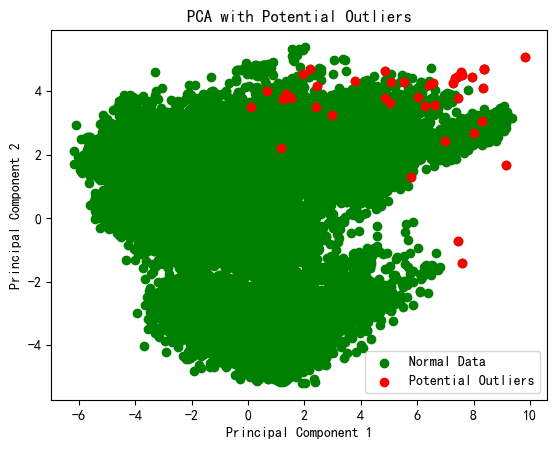

In [23]:
data=train_scaled

from sklearn.ensemble import IsolationForest

def isolation_forest(data):
    data_pure=data.copy()
    
#     model = IsolationForest(contamination=0.010650427383702971, random_state=0)
    model = IsolationForest(contamination=0.01, random_state=0)
    
    drop_cols=[f for f in data_pure.columns if f in target]
    model.fit(data_pure.drop(columns=drop_cols))

    # Predict the anomaly scores for each data point
    anomalies = model.predict(data_pure.drop(columns=drop_cols))

    outliers = anomalies == -1

    # Combine the outlier information with the original data and labels
    data_pure['outlier_ISF'] = outliers

    # Print the identified outliers
    identified_outliers = data_pure[data_pure['outlier_ISF']]
    print(f"Number of detected Potential outliers: {identified_outliers.shape[0]}")
    
    data_clean=data[~data_pure['outlier_ISF']]
    print(data_clean.shape)
    
    return data_clean


data_clean=isolation_forest(data).reset_index(drop=True)

from sklearn.neighbors import LocalOutlierFactor
params={'n_neighbors': 13, 'contamination': 0.01}

def lof(data):
    data_pure=data.copy()
    drop_cols=[f for f in data_pure.columns if f in target]

    features = data_pure.drop(columns=drop_cols)
    lof = LocalOutlierFactor(**params)  # Adjust contamination based on your data
    anomalies = lof.fit_predict(features)  # Negative scores are outliers

    outliers = anomalies == -1

    # Combine the outlier information with the original data and labels
    data_pure['outliers_LOF'] = outliers

    # Print the identified outliers
    identified_outliers = data_pure[data_pure['outliers_LOF']]
    print(f"Number of detected Potential outliers: {identified_outliers.shape[0]}")
    
    data_clean=data[~data_pure['outliers_LOF']]
    print(data_clean.shape)
    
    return data_clean

data_clean=lof(data_clean).reset_index(drop=True)

def pca_anamolies(data):
    data_pure=data.copy()
    drop_cols=[f for f in data_pure.columns if f in target]

    features = data_pure.drop(columns=drop_cols)

    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)

    pca = PCA(n_components=2)  # Choose the number of components for visualization
    principal_components = pca.fit_transform(scaled_features)

    # Calculate the reconstruction error (MSE) for each data point
    reconstruction_errors = ((scaled_features - pca.inverse_transform(principal_components)) ** 2).mean(axis=1)

    # Set a threshold for anomaly detection
    threshold = 2.5 # Adjust the threshold based on your data and desired sensitivity

    # Identify potential outliers
    potential_outliers = [index for index, error in enumerate(reconstruction_errors) if error > threshold]

    # Create a new column 'outliers' in the DataFrame
    data_pure['outliers_PCA'] = False
    data_pure.loc[potential_outliers, 'outliers_PCA'] = True

    print(f"Number of detected Potential outliers: {len(potential_outliers)}")
    
    data_clean=data[~data_pure['outliers_PCA']]
    print(data_clean.shape)

    # Plot the data with potential outliers highlighted
    plt.scatter(principal_components[:, 0], principal_components[:, 1], c='green', label='Normal Data')
    plt.scatter(principal_components[potential_outliers, 0], principal_components[potential_outliers, 1], c='red', label='Potential Outliers')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.title('PCA with Potential Outliers')
    plt.show()
    return data_clean

data_clean=pca_anamolies(data_clean).reset_index(drop=True)

In [24]:
X_train = data_clean.drop(columns=[target])
y_train = data_clean[target]
X_test = test_scaled.copy()

In [25]:
from catboost import  CatBoostRegressor 
import xgboost as xgb
# !pip install lightgbm --install-option=--gpu --install-option="--boost-root=C:/local/boost_1_69_0" --install-option="--boost-librarydir=C:/local/boost_1_69_0/lib64-msvc-14.1"
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, KFold
def get_most_important_features(X_train, y_train, n,model_input):
    
    lgb_params = {
            'n_estimators': 100,
            'max_depth': 6,
            "num_leaves": 16,
            'learning_rate': 0.05,
            'subsample': 0.7,
            'colsample_bytree': 0.8,
            #'reg_alpha': 0.25,
            'reg_lambda': 5e-07,
            'objective': 'regression_l2',
            'metric': 'mean_absolute_error',
            'boosting_type': 'gbdt',
            'random_state': 42,
            'verbose':-1
        }
    cb_params = {
            'iterations': 300,
            'depth': 6,
            'learning_rate': 0.01,
            'l2_leaf_reg': 0.5,
            'random_strength': 0.2,
            'max_bin': 150,
            'od_wait': 80,
            'one_hot_max_size': 70,
            'grow_policy': 'Depthwise',
            'bootstrap_type': 'Bayesian',
            'od_type': 'IncToDec',
            'eval_metric': 'MSLE',
            'loss_function': 'RMSE',
            'random_state': 42,
             'verbose':False
        }
     
    xgb_params = {
            'n_estimators': 500,
            'max_depth': 6,
            'learning_rate': 0.0116,
            'colsample_bytree': 1,
            'min_child_weight': 9,
            'n_jobs': -1,
            'eval_metric': 'rmsle',
            'objective': "reg:squarederror",
            'tree_method': 'hist',
            'verbosity': 0,
            'random_state': 42,
        }
    if 'xgb' in model_input:
        model = xgb.XGBRegressor(**xgb_params)
    elif 'cat' in model_input:
        model=CatBoostRegressor(**cb_params)
    else:
        model=lgb.LGBMRegressor(**lgb_params)
    
    

    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    rmse_scores = []

    for train_idx, val_idx in kfold.split(X_train,y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        if 'lgb' in model_input:
            model.fit(X_train_fold, y_train_fold)
        else:
            model.fit(X_train_fold,y_train_fold,verbose=False)

        y_pred = model.predict(X_val_fold)

        rmses = np.sqrt(mean_squared_error(y_val_fold,y_pred))
        rmse_scores.append(rmses)

    avg_rmse = np.mean(rmse_scores)

    feature_importances = model.feature_importances_

    feature_importance_list = [(X_train.columns[i], importance) for i, importance in enumerate(feature_importances)]

    sorted_features = sorted(feature_importance_list, key=lambda x: x[1], reverse=True)

    top_n_features = [feature[0] for feature in sorted_features[:n]]
    print(avg_rmse)
    return top_n_features

In [26]:
n_imp_features_cat=get_most_important_features(X_train.reset_index(drop=True), y_train,round(len(final_features)*3/4), 'cat')
n_imp_features_xgb=get_most_important_features(X_train.reset_index(drop=True), y_train,round(len(final_features)*3/4), 'xgb')
n_imp_features_lgbm=get_most_important_features(X_train.reset_index(drop=True), y_train,round(len(final_features)*3/4), 'lgbm')

0.5494800094284074
0.5204397424452301
0.5461690587622847


In [27]:
n_imp_features=[*set(n_imp_features_lgbm+n_imp_features_cat+n_imp_features_xgb)]
print(f"{len(n_imp_features)} features have been selected from three algorithms for the final model")

X_train=X_train[n_imp_features]
X_test=X_test[n_imp_features]

63 features have been selected from three algorithms for the final model


In [28]:
data_final_train = pd.concat([X_train,y_train],axis=1)
data_final_train.to_csv(f'./train_test_data/data_final_train_{len(n_imp_features)}_features.csv',index=False)

data_final_test = pd.concat([X_test,y_test],axis=1)
data_final_test.to_csv(f'./train_test_data/data_final_test_{len(n_imp_features)}_features.csv',index=False)